# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<blue>**The dataset represents 17 marketing campaigns conducted by a Portuguese bank between May 2008 and November 2010, comprising 79,354 contacts in total**</blue>

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [4]:
!nvidia-smi
!pip install -q cudf-cu12 cuml-cu12 cupy-cuda12x --extra-index-url=https://pypi.nvidia.com

import pandas as pd
import time
import cupy as cp
import cudf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split

# CPU preprocessing + models
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV as SKGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier

# GPU models
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC

from sklearn.metrics import roc_curve, auc

/bin/bash: line 1: nvidia-smi: command not found


/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Berkeley_Professional_Certificate_ML_AI/Module_17-BankingCallCenterProject/data/bank-additional-full.csv', sep = ';')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



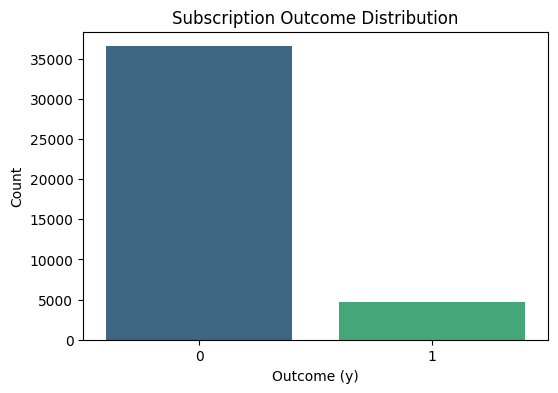

In [18]:
y = df['y']
plt.figure(figsize=(6,4))
sns.countplot(x=y, hue=y, palette='viridis', legend=False)
plt.title('Subscription Outcome Distribution')
plt.xlabel('Outcome (y)')
plt.ylabel('Count')
plt.show()

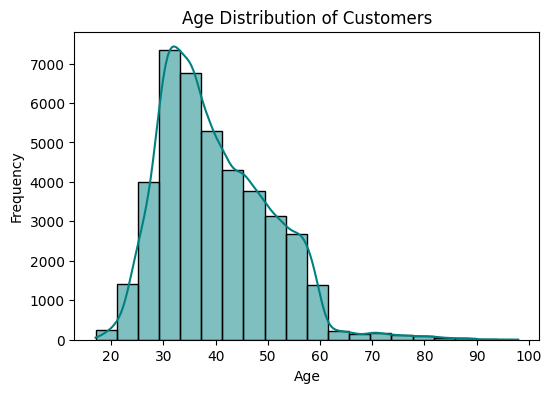

In [19]:
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=20, kde=True, color='teal')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

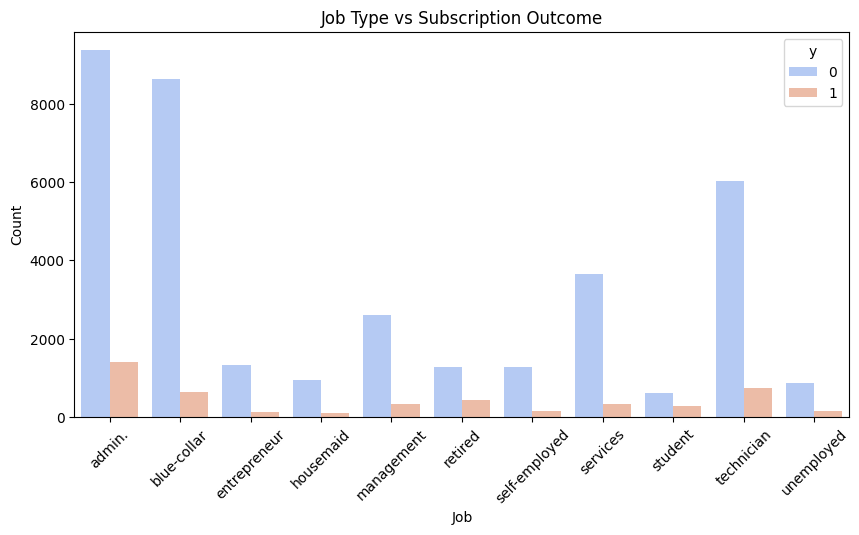

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x='job', hue='y', data=df, palette='coolwarm')
plt.title('Job Type vs Subscription Outcome')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-1852721412.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y='pdays', data=df, palette='Set2')


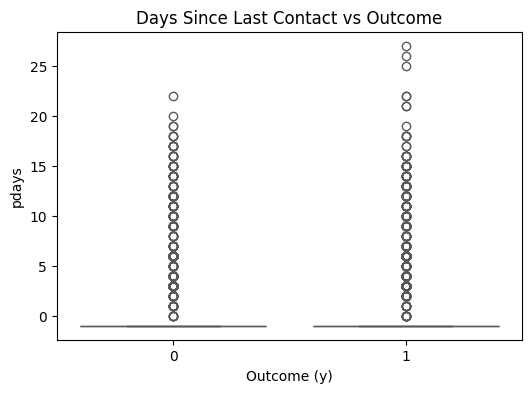

In [24]:
# pdays vs outcome (recent contact effect)
plt.figure(figsize=(6,4))
sns.boxplot(x='y', y='pdays', data=df, palette='Set2')
plt.title('Days Since Last Contact vs Outcome')
plt.xlabel('Outcome (y)')
plt.ylabel('pdays')
plt.show()


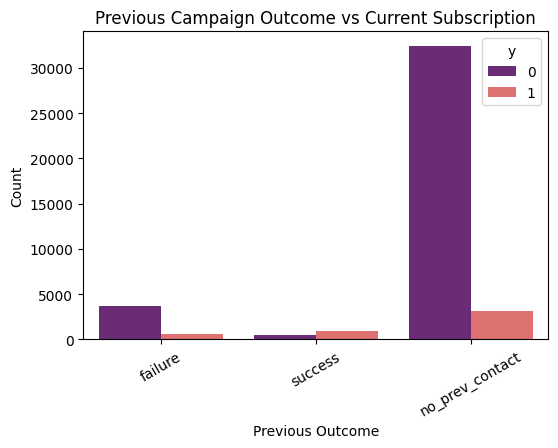

In [25]:
# previous campaign outcome vs subscription
plt.figure(figsize=(6,4))
sns.countplot(x='poutcome', hue='y', data=df, palette='magma')
plt.title('Previous Campaign Outcome vs Current Subscription')
plt.xlabel('Previous Outcome')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

**Data cleaning Plan**

1. Properly format data into numerical and categorical \
   If any non numerical data appear in numerical features, replace with NaN \
   Convert catagorical features to category data type

2. Replace 'unknown' and 'nonexistent' with NaN so they can be treated as missing data rather than real categories

3. A value of pdays = 999 means the client was never contacted before, so replace it with NaN to avoid misleading averages

4. Remove data leakage - Drop the duration column because it’s only known after the marketing call — using it would give the model unfair future information.

5. Encode the target - Convert the target variable from text (‘yes’, ‘no’) to numbers (1, 0)

6. Mode impuation - For 'job', 'marital', 'housing', 'loan', 'education', 'default', fill the missing categories with the most common value (mode) so the data stays usable and balanced and we don't have to drop rows.

7. Is missing data actually meaningful behavior ? is there meaning in missingness ? Check if what is missing is telling us something about customer response. \
New columns (pdays_missing, poutcome_missing) mark where data is missing (1 = missing, 0 = present). This helps capture patterns — e.g., clients never contacted before. \
'pdays' is filled with -1 so it stays numeric but still signals “no previous contact.” \
Create a new category 'no_prev_contact' for 'poutcome' for missing cases instead of deleting them

8. Define preprocessing for numeric and categorical columns \
Scaling of numeric features (StandardScaler) \
Correct categorical encoding (OneHotEncoder) \
Combine transformations (ColumnTransformer) and create a Pipeline for processing the models.


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Business objective** : Improve the efficiency of customer direct phone call marketing campaign, by using the best model to identify potential customers who are most likely to create a term deposit at the bank thereby optimizing marketing costs, improving conversion rates and saving money for the bank.

To further simplify it for my team of bosses, I would state it like this:  \
**I want to build a computer model that can guess who will say yes — so that we don’t waste time calling everyone and wasting money.  :-)**

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [8]:
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome'
]

numeric_cols = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]
df[numeric_cols + ['duration']] = df[numeric_cols + ['duration']].apply(pd.to_numeric, errors='coerce')
df[categorical_cols] = df[categorical_cols].astype('category')

# Replace 'unknown' and 'nonexistent' with NaN
df = df.replace({'unknown': np.nan, 'nonexistent': np.nan})
df[categorical_cols] = df[categorical_cols].astype('category')

#Replace pdays == 999 (never contacted before) with NaN
df.loc[df['pdays'] == 999, 'pdays'] = np.nan

# Drop 'duration' (data leakage) as duration is only known after the call is made
df.drop(columns=['duration'], inplace=True)

#encode target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype('int8')

/tmp/ipython-input-2165114736.py:15: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df = df.replace({'unknown': np.nan, 'nonexistent': np.nan})


In [9]:
#Handle small-missing categorical variables (mode imputation)

for col in ['job', 'marital', 'housing', 'loan', 'education', 'default']:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
#Check if missing data may have some meaning for pdays and poutcome

# Create missingness indicator flags
df['pdays_missing'] = df['pdays'].isna().astype(int)
df['poutcome_missing'] = df['poutcome'].isna().astype(int)

df['pdays'] = df['pdays'].fillna(-1)

# Add explicit category for poutcome missing values
if 'no_prev_contact' not in df['poutcome'].cat.categories:
    df['poutcome'] = df['poutcome'].cat.add_categories(['no_prev_contact'])
df['poutcome'] = df['poutcome'].fillna('no_prev_contact')

#Missingness correlation analysis
missing_df = df.isna().astype(int)
missing_corr = missing_df.corr()

for col in df.columns:
    if df[col].isna().sum() > 0:
        df[f'{col}_missing'] = df[col].isna().astype(int)

missing_flags = [c for c in df.columns if c.endswith('_missing')]
df_corr_with_y = df[missing_flags + ['y']].corr()['y'].sort_values(ascending=False)
print(df_corr_with_y)




y                   1.000000
poutcome_missing   -0.193507
pdays_missing      -0.324877
Name: y, dtype: float64


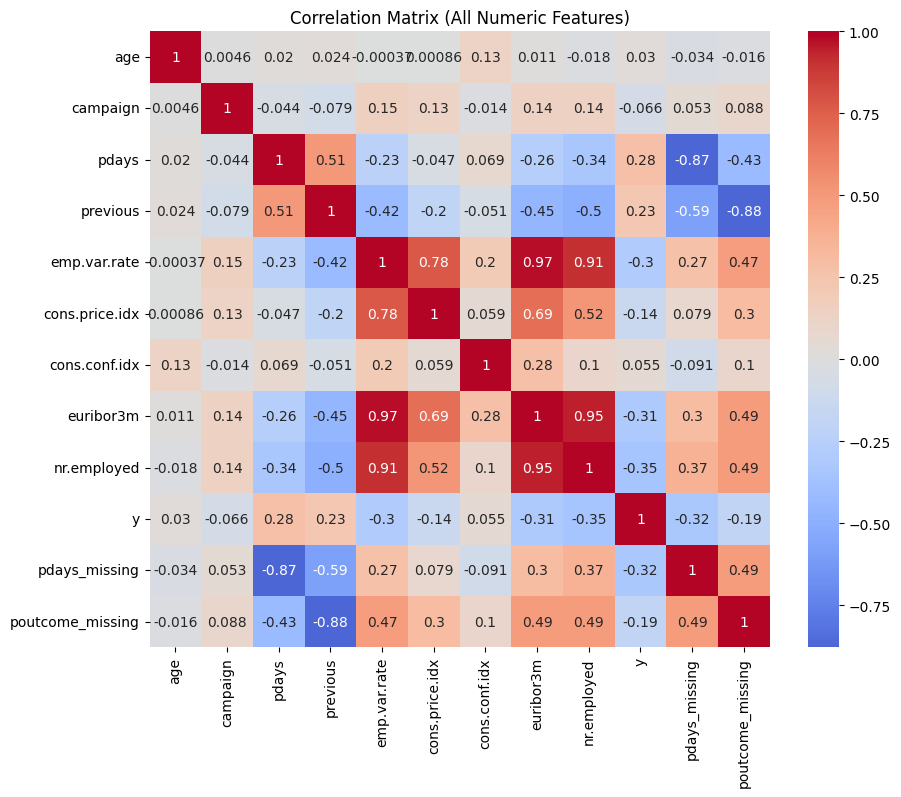

In [10]:
df_corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (All Numeric Features)')
plt.show()

**Notes**
The negative correaltions mean that if no previous contact result (poutcome is missing) prospect is less likly to create a FD
When pday is missing (never contacted before) prospect is even less liker to create FD


In [11]:
#Verify final dataset

print(df[['pdays', 'poutcome', 'pdays_missing', 'poutcome_missing']].head())
print("\nRemaining missing values:\n", df.isna().sum().sort_values(ascending=False).head(10))


   pdays         poutcome  pdays_missing  poutcome_missing
0   -1.0  no_prev_contact              1                 1
1   -1.0  no_prev_contact              1                 1
2   -1.0  no_prev_contact              1                 1
3   -1.0  no_prev_contact              1                 1
4   -1.0  no_prev_contact              1                 1

Remaining missing values:
 age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
dtype: int64


**Do PREPROCESSING of data**

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    n_jobs=1 # Explicitly set n_jobs to 1 to avoid potential issues with GPU context in multiprocessing
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [ ]:
X = df.drop('y', axis=1)
y = df['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [ ]:
df['y'].value_counts(normalize=True)

,proportion
y,
0,0.887346
1,0.112654


**Majority class approach (Most frequent)** - If I guess that everyone I call from this dataset will say 'no', then I will be correct **89%** of the time and wrong **11%** of the time. \
*(However my recall for 'yes' customers will be 0 which means with this approach, I am unable to identify which customer will say 'yes' before making the call)*

In [ ]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = dummy.predict(X_test.to_numpy())
y_prob = dummy.predict_proba(X_test.to_numpy())[:, 1]
auc = roc_auc_score(y_test.to_numpy(), y_prob)

print("Baseline Accuracy:", accuracy_score(y_test.to_numpy(), y_pred))
print("Baseline Precision:", precision_score(y_test.to_numpy(), y_pred))
print("Baseline Recall:", recall_score(y_test.to_numpy(), y_pred))
print("Baseline F1 Score:", f1_score(y_test.to_numpy(), y_pred))
print(f"Baseline AUC: {auc:.4f}")

Baseline Accuracy: 0.8873512988589464
Baseline Precision: 0.0
Baseline Recall: 0.0
Baseline F1 Score: 0.0
Baseline AUC: 0.5000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Stratified Random approach** - I will guess 'yes' for 10% of the cases and 'no' for 90% of the cases to mimic class imbalance. in some of the cases and I may get lucky and and correctly guess 'yes'.   \
*(I will generate some precision, recall, F1 score and AUC)*

In [ ]:
baseline_stratified = DummyClassifier(strategy='stratified', random_state=42)
baseline_stratified.fit(X_train.to_numpy(), y_train.to_numpy())
pred_stratified = baseline_stratified.predict(X_test.to_numpy())
prob_stratified = baseline_stratified.predict_proba(X_test.to_numpy())[:, 1]

accuracy = accuracy_score(y_test.to_numpy(), pred_stratified)
precision = precision_score(y_test.to_numpy(), pred_stratified, pos_label=1)
recall = recall_score(y_test.to_numpy(), pred_stratified, pos_label=1)
f1 = f1_score(y_test.to_numpy(), pred_stratified, pos_label=1)
auc = roc_auc_score(y_test.to_numpy(), prob_stratified)

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

Accuracy:  0.8037
Precision: 0.1218
Recall:    0.1196
F1 Score:  0.1207
AUC:       0.5051


**Heuristic approach** - I will use domain knowledge to make a prediction. Like if the prospect does not have housing loan and has agreed to create FD bedore, then guess 'yes'. \
*(It will generate some precision, recall, F1 score and AUC)*



In [ ]:
y_pred_rule = np.where(
    (X_test['previous'].to_numpy() > 0) & (X_test['housing'].to_numpy() == 'no'), 1, 0
)
# Compute evaluation metrics
accuracy = accuracy_score(y_test.to_numpy(), y_pred_rule)
precision = precision_score(y_test.to_numpy(), y_pred_rule, zero_division=0)
recall = recall_score(y_test.to_numpy(), y_pred_rule, zero_division=0)
f1 = f1_score(y_test.to_numpy(), y_pred_rule, zero_division=0)
auc = roc_auc_score(y_test.to_numpy(), y_pred_rule)

# Display results neatly
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")

Accuracy:  0.861
Precision: 0.273
Recall: 0.142
F1 Score: 0.187
AUC: 0.547


**BASELINE MODEL KPI TO BEAT**



                          Accuracy    Precision       Recall      F1 Score      AUC
**Majority class** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.88 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;       0.0  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            0.0 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        0.0 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       0.5  

**Stratified Random** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.80 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;0.12  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.11 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.12 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.5

**Heuristic** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.86 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;0.27  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.14 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.19 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.547

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [ ]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

start_time = time.time()
log_reg.fit(X_train, y_train)
fit_time = time.time() - start_time

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

### Problem 9: Score the Model

What is the accuracy of your model?

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"AUC      : {auc:.3f}")
print(f"Fit Time : {fit_time:.2f} seconds")

Accuracy : 0.901
Precision: 0.695
Recall   : 0.211
F1 Score : 0.324
AUC      : 0.801
Fit Time : 1.49 seconds


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True)
}

In [ ]:
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = round(time.time() - start_time, 2)

    y_pred = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['classifier'], "predict_proba") else None

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append({
        "Model": name,
        "Train Time (s)": train_time,
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })


In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
print("\nModel Performance Comparison:\n")
print(df_results.to_string(index=False))


Model Performance Comparison:

              Model  Train Time (s)  Train Accuracy  Test Accuracy  Precision  Recall  F1 Score   AUC
                SVM            6.72           0.905          0.902      0.717   0.216     0.331 0.717
Logistic Regression            1.31           0.899          0.901      0.695   0.211     0.324 0.801
                KNN            1.06           0.912          0.896      0.572   0.304     0.397 0.746
      Decision Tree            0.35           0.995          0.844      0.318   0.334     0.326 0.622


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
# CPU
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

X_train_prep = np.asarray(X_train_prep, dtype=np.float32)
X_test_prep  = np.asarray(X_test_prep, dtype=np.float32)

# GPU
X_train_gpu = cudf.DataFrame.from_records(X_train_prep)
X_test_gpu  = cudf.DataFrame.from_records(X_test_prep)
y_train_gpu = cudf.Series(y_train.values.astype(np.int32))
y_test_gpu  = cudf.Series(y_test.values.astype(np.int32))

# Hyper parameter grids ---
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10]
    },
    "Decision Tree": {
        'max_depth': [3, 5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform']
    },
    "SVM": {
        'C': [0.5, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

#Train and evaluate
results = []
tuned_models = {}

for name, model in models.items():
    print(f"\nTuning {name} ...")
    start = time.time()

    #CPU models
    if name in ["Logistic Regression", "Decision Tree"]:
        grid = SKGrid(model, param_grids[name], scoring='f1', cv=5, n_jobs=-1)
        grid.fit(X_train_prep, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_prep)
        y_prob = best_model.predict_proba(X_test_prep)[:, 1]
        y_train_pred = best_model.predict(X_train_prep)

    #GPU models
    else:
        best_f1 = -1
        best_params = None
        best_model = None

        keys, values = zip(*param_grids[name].items())
        for combo in itertools.product(*values):
            params = dict(zip(keys, combo))
            model.set_params(**params)
            model.fit(X_train_gpu, y_train_gpu)

            preds = model.predict(X_test_gpu)

            try:
                probs = model.predict_proba(X_test_gpu)
                if hasattr(probs, "shape") and probs.shape[1] > 1:
                    probs = probs[:, 1]
                else:
                    probs = preds
            except Exception:
                probs = preds

            preds_cpu = preds.to_numpy() if hasattr(preds, "to_numpy") else np.asarray(preds)
            probs_cpu = probs.to_numpy() if hasattr(probs, "to_numpy") else np.asarray(probs)

            f1s = f1_score(y_test, preds_cpu)
            if f1s > best_f1:
                best_f1 = f1s
                best_params = params.copy()
                best_model = model

        y_pred = best_model.predict(X_test_gpu)
        try:
            y_prob = best_model.predict_proba(X_test_gpu)
            if hasattr(y_prob, "shape") and y_prob.shape[1] > 1:
                y_prob = y_prob[:, 1]
            else:
                y_prob = best_model.predict(X_test_gpu)
        except Exception:
            y_prob = best_model.predict(X_test_gpu)

        y_pred = y_pred.to_numpy() if hasattr(y_pred, "to_numpy") else np.asarray(y_pred)
        y_prob = y_prob.to_numpy() if hasattr(y_prob, "to_numpy") else np.asarray(y_prob)

        y_train_pred = best_model.predict(X_train_gpu)
        y_train_pred = y_train_pred.to_numpy() if hasattr(y_train_pred, "to_numpy") else np.asarray(y_train_pred)

    #Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1s = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) == 2 else np.nan

    results.append({
        "Model": name,
        "Train Time (s)": round(time.time() - start, 2),
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Precision": round(pre, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1s, 3),
        "AUC": round(auc, 3)
    })

df_results = pd.DataFrame(results)
df_results = df_results[
    ["Model", "Train Time (s)", "Train Accuracy", "Test Accuracy",
     "Precision", "Recall", "F1 Score", "AUC"]
]
print("\nModel Performance Comparison:\n")
print(df_results.to_string(index=False))


Tuning Logistic Regression ...

Tuning KNN ...

Tuning Decision Tree ...

Tuning SVM ...

Model Performance Comparison:

              Model  Train Time (s)  Train Accuracy  Test Accuracy  Precision  Recall  F1 Score   AUC
Logistic Regression            3.89           0.899          0.901      0.692   0.213     0.326 0.800
                KNN            0.23           0.906          0.899      0.609   0.282     0.386 0.630
      Decision Tree            1.84           0.915          0.898      0.595   0.290     0.390 0.783
                SVM          684.54           0.921          0.897      0.667   0.172     0.274 0.581


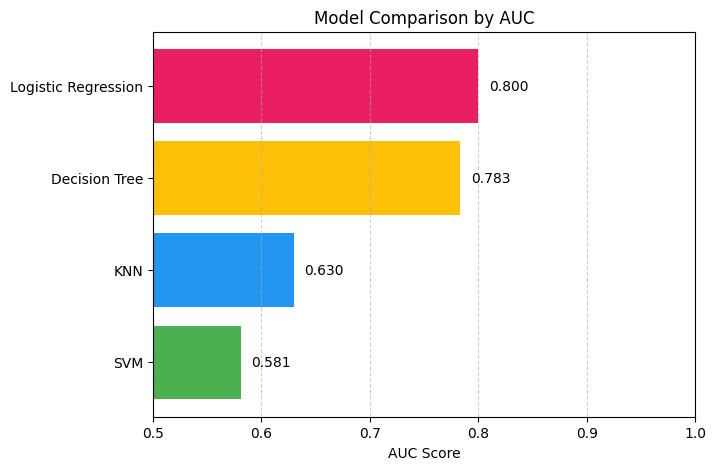

In [5]:
models = ["Logistic Regression", "KNN", "Decision Tree", "SVM"]
auc_scores = [0.800, 0.630, 0.783, 0.581]

# Sort by AUC for clearer ranking
sorted_idx = np.argsort(auc_scores)
models_sorted = [models[i] for i in sorted_idx]
auc_sorted = [auc_scores[i] for i in sorted_idx]

plt.figure(figsize=(7,5))
bars = plt.barh(models_sorted, auc_sorted, color=['#4CAF50', '#2196F3', '#FFC107', '#E91E63'])
plt.title('Model Comparison by AUC')
plt.xlabel('AUC Score')
plt.xlim(0.5, 1.0)

# Annotate AUC values on bars
for bar, auc in zip(bars, auc_sorted):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{auc:.3f}", va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


**RESULT ANALYSIS:**
Tuning did not improve the models much, Decision Tree showed the best F1 Score improvement (+0.064)

**Logistic Regression** had the most balanced metrics (highest test accuracy, highest precision, good recall and highest AUC (0.80).

SVM’s long runtime and lower metrics make it inefficient for production use.
